In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.trainers as tr
import importlib as imp
import numpy as np

In [2]:
read_features_targets_kwargs = {'fields_to_read' :    {"B": True,"B_ext": False,"divB": False,"E": True,"E_ext": False,"rho": True,"J": True,
                                                      "P": True,"PI": True,"Heat_flux": False,"N": False,"Qrem": False}, # which fields to read
                                'request_features' :  ['rho_e', 'Bx', 'By', 'Bz', 'Vx_e', 'Vy_e', 'Vz_e', 'Ex', 'Ey', 'Ez'],  # what network needs to make predictions
                                'request_targets' :   ["Pxx_e", "Pyy_e","Pzz_e","Pxy_e","Pxz_e","Pyz_e"],                     # what we want to predict
                                'choose_species' :    ['e',None],   # which species to take
                                'choose_x' : [0,128], 'choose_y' : [0,128], 'verbose' : False  # which part of the domain to take. The full domain is 2048x2048 and is too heavy for the tutorial
                          } # make sure not to put a comma here, otherwise the object becomes a tuple rather than a dictionary which causes all sorts of problems

In [3]:
dataset_kwargs = {'data_folder': "/volume1/scratch/share_dir/ecsim/peppe/T2D14_filter2/",               # where the data is stored
                          'image_file_name_column' : 'filenames',                       # the column in the csv file that contains the image file names
                          'read_features_targets_kwargs' : read_features_targets_kwargs,
                          'train_sample' :  "/volume1/scratch/share_dir/nathan_test/train.csv",  # this should be the path to the csv file that contains a list of training samples, each cell corresponds to local paths to the actual data relative to `data_folder`
                          'val_sample' :    "/volume1/scratch/share_dir/nathan_test/val.csv",    # same but validation
                          'test_sample' :   "/volume1/scratch/share_dir/nathan_test/test.csv",   # same but testing
                          'scaler_features' : True,    # Whether to normalize the features. It is called scaler because it rescales to 0 mean and 1 variance
                          'scaler_targets' : True,     # Whether to normalize the targets
                          'prescaler_targets' : ['log','log','log',None,None,None]  # If we want to transform the targets before training. The order in which they appear correspond to `request_targets` in `read_features_targets_kwargs``
                      }

In [4]:
import pandas as pd
pd.read_csv(dataset_kwargs['train_sample'])

,filenames
0,T2D-Fields_000000.h5.pkl
1,T2D-Fields_000001.h5.pkl
2,T2D-Fields_000500.h5.pkl
3,T2D-Fields_001000.h5.pkl
4,T2D-Fields_001500.h5.pkl
5,T2D-Fields_002000.h5.pkl
6,T2D-Fields_002500.h5.pkl
7,T2D-Fields_003000.h5.pkl
8,T2D-Fields_003500.h5.pkl
9,T2D-Fields_004000.h5.pkl


In [5]:
load_data_kwargs={'train_loader_kwargs' : {'batch_size' : 512,      #training batch size
                                           'subsample_rate' : .2,   #subsample rate which defines a fraction of data that is used when sampling. 1 means all data is used
                                           'subsample_seed' : 42,   #seed for the subsampling
                                           'seed' : 42,             #seed for the random number generator
                                           'shuffle' : True},       #shuffle the training set
                    'val_loader_kwargs' : {'batch_size' : 512,        #validation batch size
                                           'subsample_rate' : .2, 
                                           'subsample_seed' : 42, 
                                           'shuffle' : False}}      # we don't need to shuffle the validation set

In [6]:
model_kwargs={'model': 'MLP',    # the model class name we want to use, check `src/models.py` for available models
              'model_seed' : 42, # seed for the random initialization of the model
              'feature_dims' : [10, 60, 80, 50, 40, 6], # the dimensions of the layers in the model. The first element should be the number of `request_features` in `read_features_targets_kwargs` and the last element should be the number of `request_targets` in `read_features_targets_kwargs`
              'activations' : ['Tanh','Tanh','ReLU','Tanh', None], 
    'optimizer_kwargs': {'optimizer' : 'Adam',      # look up https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam 
                         'lr' : 5e-4,               # learning rate
                         'criterion': 'MSELoss'},   # the loss function to optimize
    'scheduler_kwargs': {'scheduler' : 'ReduceLROnPlateau',  # look up https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
                         'mode' : 'min',  # the remainder are the arguments for the ReduceLROnPlateau scheduler
                         'factor' : 0.2, 
                         'patience' : 10, 
                         'cooldown' : 15 , 
                         'epochs' : 10,                 # number of epochs before stoppig training
                         'early_stopping' : 20},        # number of epochs to tolarate without 
    'logger_kwargs':{'update_step': 1, 'show': True}}   # some details about how to log the training process

In [7]:
work_dir = '/volume1/scratch/georgem/closure/models/dev/dev_nathan/'  # you may have to create containing path before running the script (check in the source code). It is better to use absolute paths than relative paths for the operations below to work
                                                                            # the /dev16/ folder on the other hand will be definitely created by the trainer so you don't need to create it
! rm -rf {work_dir}  # This will delete the previously existing model
trainer = tr.Trainer(work_dir=work_dir,   # where the model will be saved
                     dataset_kwargs=dataset_kwargs, load_data_kwargs=load_data_kwargs, model_kwargs=model_kwargs)

INFO:src.trainers:Creating a new configuration file: /volume1/scratch/georgem/closure/models/dev/dev_nathan/config.json
2025-07-02 09:25:21,950 | INFO | src.datasets | 	  This is train set
2025-07-02 09:25:21,950 | INFO | src.datasets | 	 Datasplit performed according to /volume1/scratch/share_dir/nathan_test/train.csv
2025-07-02 09:25:22,335 | WARNING | src.read_pic | 	 Failed to calculate Ppar for e likely due to missing fields, see: 'e'
2025-07-02 09:25:22,335 | WARNING | src.read_pic | 	 Failed to calculate Ppar for e likely due to missing fields, see: 'e'
2025-07-02 09:25:22,337 | WARNING | src.read_pic | 	 Failed to calculate Pperp for e likely due to missing fields, see: 'e'
2025-07-02 09:25:22,337 | WARNING | src.read_pic | 	 Failed to calculate Pperp for e likely due to missing fields, see: 'e'
2025-07-02 09:25:38,668 | WARNING | src.read_pic | 	 Failed to calculate Ppar for e likely due to missing fields, see: 'e'
2025-07-02 09:25:38,668 | WARNING | src.read_pic | 	 Failed to

KeyError: 'e'

2025-07-02 09:25:38,859 | INFO | IPKernelApp | 	 Exception in execute request:
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[7], line 4
      2                                                                             # the /dev16/ folder on the other hand will be definitely created by the trainer so you don't need to create it
      3 get_ipython().system(' rm -rf {work_dir}  # This will delete the previously existing model')
----> 4 trainer = tr.Trainer(work_dir=work_dir,   # where the model will be saved
      5                      dataset_kwargs=dataset_kwargs, load_data_kwargs=load_data_kwargs, model_kwargs=model_kwargs)

File /volume1/scratch/georgem/closure/examples/../src/trainers.py:214, in Trainer.__init__(self, dataset_kwargs, load_data_kwargs, model_kwargs, mode_test, device, work_dir, log_name, log_level, force, timing_name, world_size, rank, gpus_per_node, 

In [8]:
! ls {work_dir}

config.json  training.log  X.pkl  y.pkl


In [9]:
print(f"trainer work dir: \t\t{trainer.work_dir}")
print(f"trainer class instance: \t{trainer}")
print(f"trainer loader: \t\t{trainer.train_loader}")
print(f"train dataset features shape: \t {trainer.train_dataset.features.shape}")
print(f"train dataset targets shape: \t{trainer.train_dataset.targets.shape}")

trainer work dir: 		/volume1/scratch/georgem/closure/models/dev/dev_nathan/
trainer class instance: 	<src.trainers.Trainer object at 0x7f3f4e1de600>
trainer loader: 		<src.datasets.ChannelDataLoader object at 0x7f3f4e94ef60>
train dataset features shape: 	 torch.Size([507904, 10])
train dataset targets shape: 	torch.Size([507904, 6])


In [10]:
import torch
torch.mean(trainer.train_dataset.features, dim=0), torch.std(trainer.train_dataset.features, dim=0)

(tensor([-1.6824e-09,  0.0000e+00,  1.2017e-10, -1.8626e-09,  1.2618e-09,
         -3.1244e-09, -1.2017e-10,  2.4034e-10,  1.8026e-10,  0.0000e+00]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]))

In [12]:
import torch
torch.mean(trainer.val_dataset.features, dim=0), torch.std(trainer.val_dataset.features, dim=0)

(tensor([-0.3237, -0.0681, -0.0268, -0.1102, -0.2223,  0.2341, -0.1928, -0.1700,
         -0.1780,  0.0015]),
 tensor([0.5638, 1.2135, 0.8783, 1.2870, 0.4415, 0.4903, 1.0953, 0.9080, 1.0165,
         1.0057]))

In [13]:
trainer.fit()

2025-06-19 17:05:00,254 | INFO | src.trainers | 	 Prior to fit: RAM memory % used: 5.2, RAM Used (GB):, 11.444219904, process RAM usage (GB): 0.4698143005371094
2025-06-19 17:05:00,255 | INFO | src.models | 	 Each forward pass had 199 train batches.
2025-06-19 17:05:02,029 | INFO | src.models | 	 Number of samples per batch: len(next(iter(train_loader))[0]) = 512
2025-06-19 17:05:05,863 | INFO | src.models | 	 Epoch 1/10 | Train loss: 6.6407e-01 | Val loss: 1.3281e+00 | Time/epoch: 3.832 s | Time/epoch_train: 2.312 s | Learn rate: [0.0005]
2025-06-19 17:05:09,824 | INFO | src.models | 	 Epoch 2/10 | Train loss: 2.4591e-01 | Val loss: 1.4889e+00 | Time/epoch: 3.96 s | Time/epoch_train: 2.393 s | Learn rate: [0.0005]
2025-06-19 17:05:13,836 | INFO | src.models | 	 Epoch 3/10 | Train loss: 1.3817e-01 | Val loss: 1.4459e+00 | Time/epoch: 4.011 s | Time/epoch_train: 2.462 s | Learn rate: [0.0005]
2025-06-19 17:05:17,691 | INFO | src.models | 	 Epoch 4/10 | Train loss: 9.7178e-02 | Val loss:

inf

In [14]:
! ls {work_dir}

config.json  loss_dict.pkl  model.pth  training.log  X.pkl  y.pkl


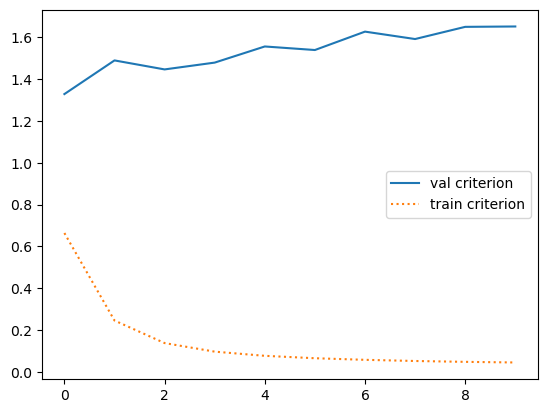

In [15]:
import matplotlib.pyplot as plt
for key, val_loss in trainer.model.val_loss_.items():
    plt.plot(val_loss, label=f'val {key}')
for key, val_loss in trainer.model.train_loss_.items():
    plt.plot(val_loss, label=f'train {key}', linestyle=':')
#plt.ylim(0, 8e-1)
plt.legend()
plt.show()

In [16]:
load_data_kwargs={'train_loader_kwargs' : {'batch_size' : 512,      #training batch size
                                           'subsample_rate' : 1,   #subsample rate which defines a fraction of data that is used when sampling. 1 means all data is used
                                           'subsample_seed' : 42,   #seed for the subsampling
                                           'seed' : 42,             #seed for the random number generator
                                           'shuffle' : True},       #shuffle the training set
                    'val_loader_kwargs' : {'batch_size' : 512,        #validation batch size
                                           'subsample_rate' : 1, 
                                           'subsample_seed' : 42, 
                                           'shuffle' : False}}      # we don't need to shuffle the validation set

In [17]:
import copy  # because configurations are a dictionary we must use deepcopy to avoid changing the original configuration
config = copy.deepcopy(trainer.config)
config['run'] = 'nosubsample'
config['load_data_kwargs'] = load_data_kwargs

In [18]:
trainer.fit(config=config)

2025-06-19 17:05:44,915 | WARNING | src.trainers | 	 ============Updating the config with the new config============
2025-06-19 17:05:44,916 | INFO | src.trainers | 	 Comprehending the configuration settings
2025-06-19 17:05:44,917 | WARNING | src.trainers | 	 Creating new model. Note this will replace any previous model
2025-06-19 17:05:44,917 | INFO | src.models | 	 torch.cuda.is_available() = False
2025-06-19 17:05:44,919 | INFO | src.models | 	 Initializing model MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4): Linear(in_features=80, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=6, bias=True)
  )
)
2025-06-19 17:05:44,919 | INFO | src.models | 	 DDP not available, initia

inf

In [19]:
! ls {work_dir}
! ls {work_dir}/nosubsample # the sub-folder contains the corresponding model, its own configuration and the training logs (run.log) specific to this run. The loss history is stored in loss_dict.pkl

config.json  loss_dict.pkl  model.pth  nosubsample  training.log  X.pkl  y.pkl
config.json  loss_dict.pkl  model.pth  run.log


In [19]:
print(f"work directory: {trainer.work_dir}")
print(f"{trainer.run = }")

work directory: /volume1/scratch/georgem/closure/models/dev/dev_nathan/
trainer.run = 'nosubsample'


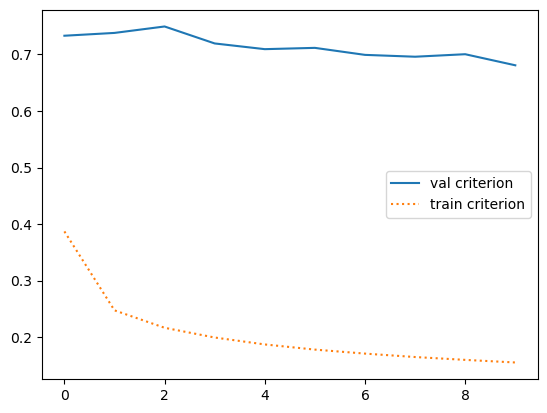

In [20]:
import matplotlib.pyplot as plt
for key, val_loss in trainer.model.val_loss_.items():
    plt.plot(val_loss, label=f'val {key}')
for key, val_loss in trainer.model.train_loss_.items():
    plt.plot(val_loss, label=f'train {key}', linestyle=':')
#plt.ylim(0, 8e-1)
plt.legend()
plt.show()

In [29]:
prediction, ground_truth, list_of_target_indices = tr.ut.pred_ground_targets(trainer)

The function pred_ground_targets is deprecated. Use transform_targets instead.
Total loss 0.8626463413238525
Loss for channel 0:  Pxx_e, loss = 0.15048007667064667
Loss for channel 1:  Pyy_e, loss = 0.16464263200759888
Loss for channel 2:  Pzz_e, loss = 0.2494594007730484
Loss for channel 3:  Pxy_e, loss = 1.824426293373108
Loss for channel 4:  Pxz_e, loss = 2.179743766784668
Loss for channel 5:  Pyz_e, loss = 0.6071262359619141


invfunc = <ufunc 'exp'>


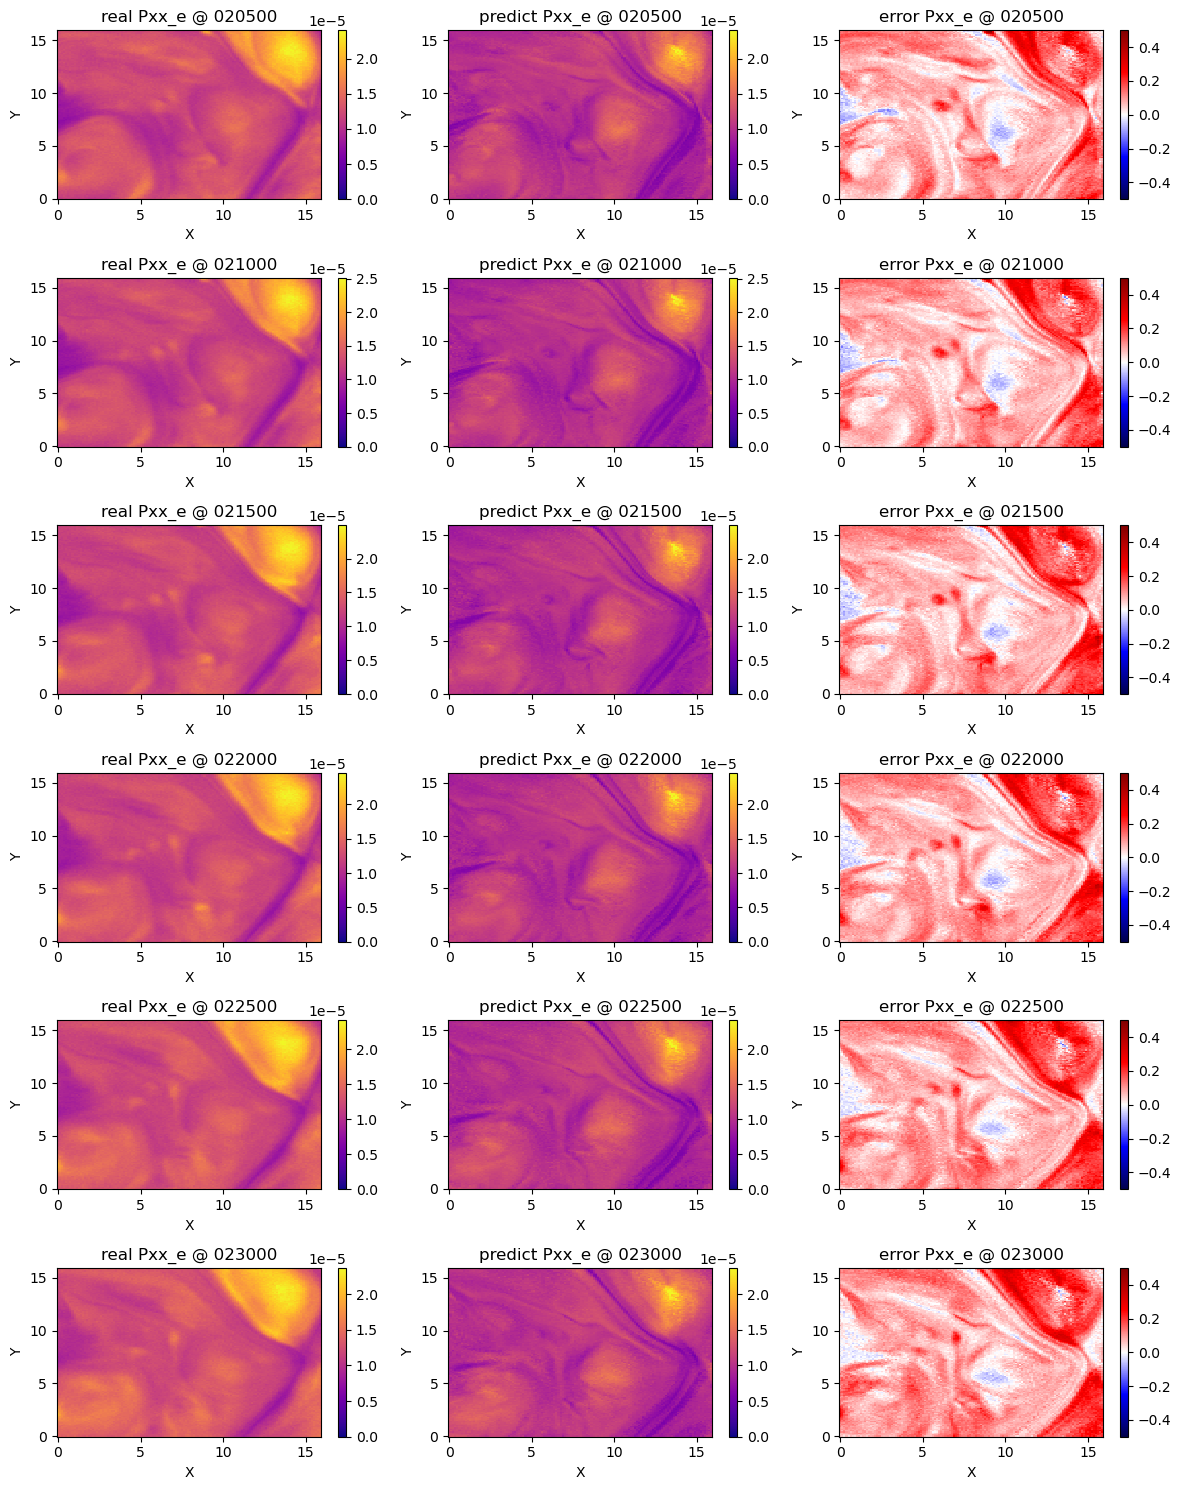

In [30]:
tr.ut.plot_pred_targets(trainer, 'Pxx_e', prediction, ground_truth, list_of_target_indices, figsize=(12,15))

invfunc = <function plot_pred_targets.<locals>.<lambda> at 0x7fd377bc0fe0>


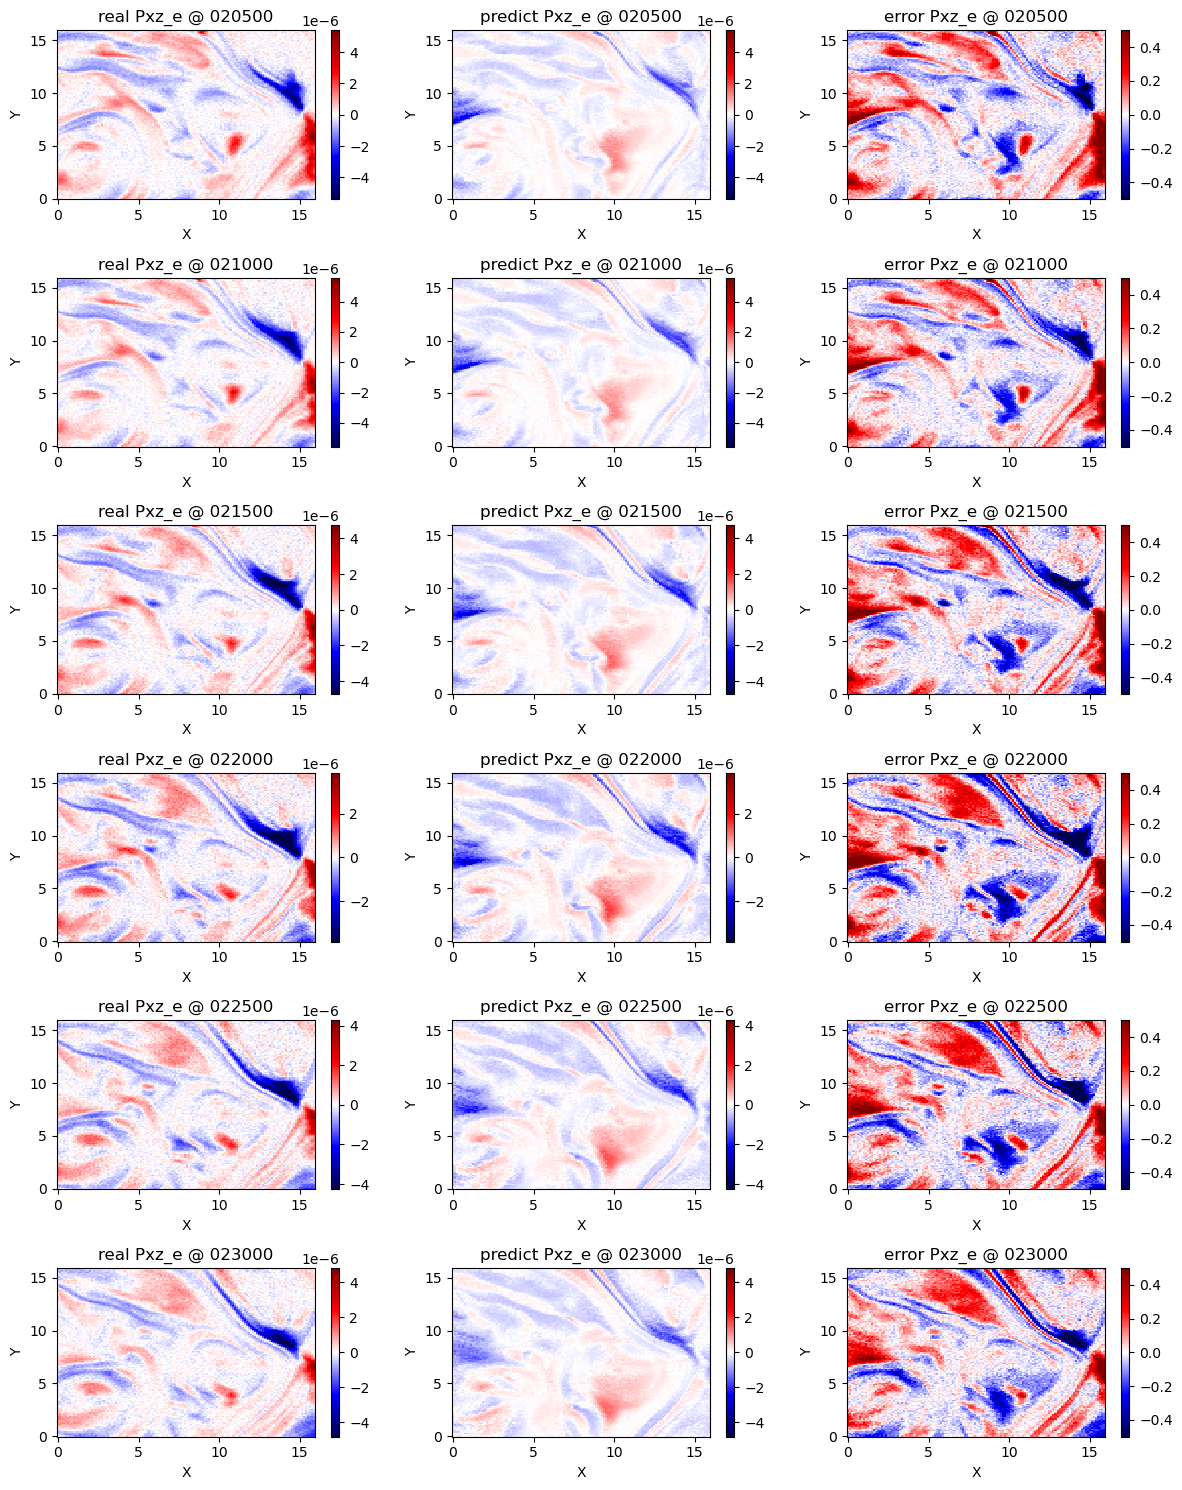

In [31]:
tr.ut.plot_pred_targets(trainer, 'Pxz_e', prediction, ground_truth, list_of_target_indices, figsize=(12,15))